## Estimates of Hawkes process

### Done by wissal Belhorma and Meriem Naji

In [1]:
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import expon, chisquare,chi2,kstest
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

### Loading the data

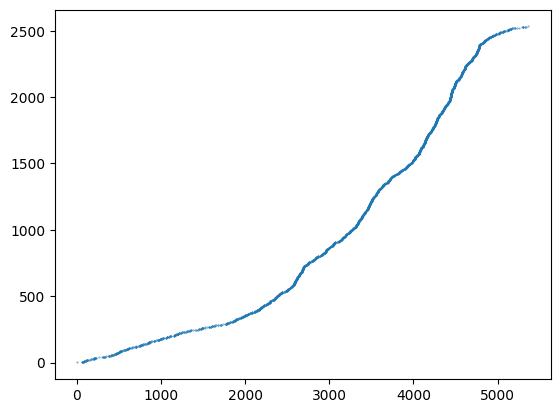

In [2]:
df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
unique_l = np.unique(l)
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.show()

### finding optimal parameters $\alpha$ and  $\beta $

We will define the log-likelihood function as :


$
\log L(N, t) = \sum_{T_n \leq t} \log \left(\alpha + \beta \sum_{j=1}^{n-1} e^{-\gamma\left(T_n-T_j\right)}\right) + (1-\alpha) t - \frac{\beta}{\gamma} \sum_{T_n \leq t} \left(1 - e^{-\gamma\left(t-T_n\right)}\right)
$

Then optimize the parameters using the minimize function from scipy

**1) We will try to guess the initial parameters**

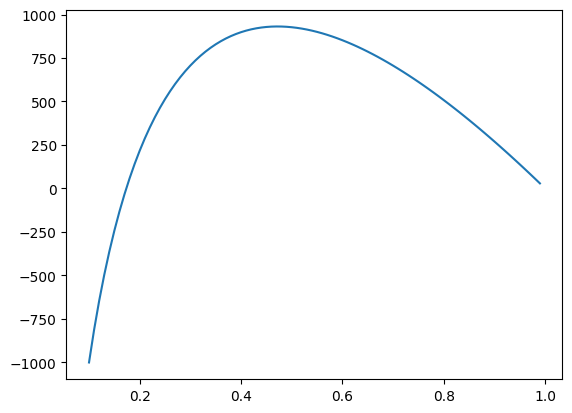

In [3]:
t = l[-1]
alphas= np.arange(0.1, 1, 0.01)
plt.plot(alphas, len(l)*np.log(alphas) + (1-alphas)*t)
plt.show()

The plot shows that the log-likelihood function has a maximum around $\alpha$=0.45 . Since the log-likelihood function represents how well the model with parameter $\alpha$ fits the data, the peak indicates the value of $\alpha$ that best fits the data under the assumption that other parameters are fixed is 0.45

So We can reasonably begin with alpha = 0.45

We choose $\beta = 0.5$ and $\gamma = 1$ initially because the first log term in the likelihood function pushes $\gamma$ towards zero and $\beta$ to be large, while the second term pushes $\beta$ towards zero and $\gamma$ to be large, so starting in the middle with $\beta = 0.5$ and $\gamma = 1$ is a balanced initial guess.


**2) Define the loglikelihood**

In [4]:

def log_likelihood(params):
    # Initialize variables
    alpha, beta, gamma = params
    t_max = l[-1]
    log_like = (1-alpha)*t_max

    # Compute the log-likelihood
    for i in range(len(l)):
        sum1 = np.sum(np.exp(-gamma*(l[i]*np.ones(i) - l[:i])))
        log_like += np.log(alpha + beta*sum1)
        log_like -= (beta/gamma) * (1-np.exp(-gamma*(t_max-l[i])))

    return -log_like

**3) optimize the parameters using the minimize function**

In [5]:


# Initial guess for the parameters
initial_params = [0.45,0.5,1]  # Initial guess for alpha, beta, gamma

# find the optimal parameters

def optimal_parameters():
    # we use the minimization function to find the optimal parameters
    constr = ({'type': 'ineq', 'fun': lambda x: x[1]/x[2]-1})
    bnds = ((0,None),(0,None),(0,None))
    res=minimize(log_likelihood,initial_params, method='L-BFGS-B',bounds=bnds,constraints=constr)
    return res.x

# find the optimal parameters for the whole dataset
alpha,beta,gamma=optimal_parameters()


/tmp/ipykernel_5814/25264870.py:10: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res=minimize(log_likelihood,initial_params, method='L-BFGS-B',bounds=bnds,constraints=constr)
/tmp/ipykernel_5814/3286028547.py:10: RuntimeWarning: divide by zero encountered in log
  log_like += np.log(alpha + beta*sum1)
/home/iliass/.local/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


**4) Print the optimal parameters**

In [6]:
print("alpha optimal = ",alpha)
print("beta optimal = ",beta)
print("gamma optimal = ",gamma)

alpha optimal =  0.38878413440464854
beta optimal =  9406.745748293673
gamma optimal =  53670.87367415645


### Computation of  $\left(y\left(N, T_q(N)\right), n \geq 1\right)$

We will compute y(N,t) using the following formula  in exercise 3.4.2
$$y(N,t)=\alpha t + \frac{\beta}{\gamma} \sum_{T_n\leq t} (1-e^{-\gamma (t-T_n)})$$

In [7]:


alpha, beta, gamma = optimal_parameters()

# Compute y

y = np.zeros(len(l))
for i in range(len(l)):
    y[i] = alpha*l[i] + beta / gamma * \
        (np.sum(1 - np.exp(-gamma * (l[i] - l[:i]))))

/tmp/ipykernel_5814/25264870.py:10: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  res=minimize(log_likelihood,initial_params, method='L-BFGS-B',bounds=bnds,constraints=constr)
/tmp/ipykernel_5814/3286028547.py:10: RuntimeWarning: divide by zero encountered in log
  log_like += np.log(alpha + beta*sum1)


Now that we have computed y, let's compare the distribution of inter-arrival times with generated poisson process .
To do so, we will compare the empirical histogram with the exponential densities

**1)Compare the mean**

In [8]:

inter_intervals = np.diff(y)
mean = np.mean(inter_intervals)
print("Sample mean:", mean)


Sample mean: 0.9979965236216773


We notice that It is almost close to the value 1 as we expected

**2)Compare the data distribution to the exponential distribution**

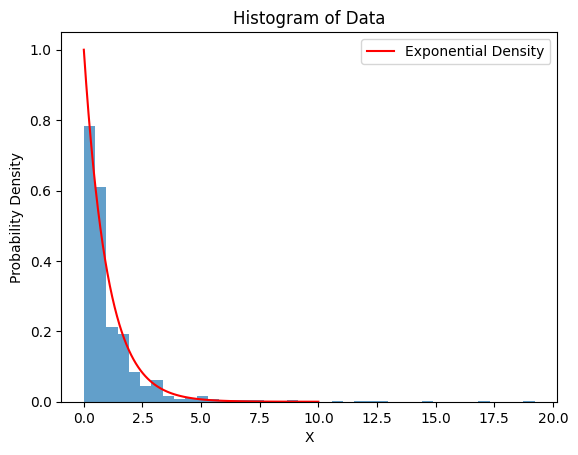

In [10]:
plt.hist(inter_intervals, bins=40, density=True, alpha=0.7)
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.title('Histogram of Data')
import scipy as sp

# Adding the theorical density plot
x_values = np.linspace(0, 10, 100)
# Exponential density with scale=1
density = sp.stats.expon.pdf(x_values, scale=1)
plt.plot(x_values, density, 'r-', label='Exponential Density')
plt.legend()

plt.show()

The histogram of the data $\left(y\left(N, T_q(N)\right), n \geq 1\right)$ closely matches the exponential density function, indicating that the distribution of the data is close to the law of a Poisson process with intensity 1.


**3)Perform the Kolmogorov-Smirnov test**

In [ ]:

# Fit the exponential distribution to the observed gap times
loc, scale = expon.fit(inter_intervals)
# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value =  stats.kstest(inter_intervals, 'expon', args=(loc, scale))
print(f"The Kolmogorov-Smirnov score is {ks_statistic} for a scale of {scale}.")

The Kolmogorov-Smirnov score is 0.3765310154089293 for a scale of 0.8038393349636515.


**Conclusion :** from the results obtained above, it looks like the generated process of intensity $y(N, t)$ is a Poisson process of intensity 1. This is what we were looking for when conducting the likelihood maximization.